# Analyzing the Chinook Database
The Chinook Database is a fictional digital music shop, similar to a mini iTunes store.  We'll use SQL to query on the database and run a few different analyses.
# The Chinook Schema
![chinook_schema](Chinook_Schema.png)

# Load the database into Jupyter Notebook

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db
from IPython.display import HTML
%%html

# Explore the database to see if it matches the schema above

In [2]:
%%sql
SELECT name,type
FROM sqlite_master
WHERE type in ('table','view');

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


# USA Best Selling Genres
We're tasked with finding the first three albums from a list of four Artists to be added to the online store.  All we currently know about the Artist's is the Genre.  They are as following:

| Artist Name | Genre |
| --- | --- |
| Regal | Hip-Hop |
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

We are interested in finding each Genre and returning the number of tracks sold in the USA by absolute numbers and percentages.  This way we can make a recommendation on which Albums to add based on best selling Genres

In [3]:
%%sql
WITH
    total as (
            SELECT 
                i.invoice_id as invoice_id, 
                i.billing_country as country,
                il.track_id as track_id,
                SUM(il.quantity) as invoice_quantity,
                t.genre_id,
                g.name as genre
            FROM invoice as i
            INNER JOIN invoice_line as il ON il.invoice_id = i.invoice_id
            INNER JOIN track as t ON t.track_id = il.track_id
            INNER JOIN genre as g ON g.genre_id = t.genre_id
            WHERE country ='USA'
            GROUP BY g.name
            )
SELECT 
    genre,
    invoice_quantity,
    round((CAST(invoice_quantity as Float) 
               / CAST(
                       (SELECT 
                            sum(invoice_quantity) 
                            FROM total) 
                        as Float)) * 100,2) 
                            || '%' AS percent_of_total_tracks
    FROM total
    ORDER BY invoice_quantity DESC
    LIMIT 10;

 * sqlite:///chinook.db
Done.


genre,invoice_quantity,percent_of_total_tracks
Rock,561,53.38%
Alternative & Punk,130,12.37%
Metal,124,11.8%
R&B/Soul,53,5.04%
Blues,36,3.43%
Alternative,35,3.33%
Latin,22,2.09%
Pop,22,2.09%
Hip Hop/Rap,20,1.9%
Jazz,14,1.33%


As we can see, the top three from the four Artists in question to be added to the marketplace should be in order Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop).  However, the most popular Genre is 'Rock' so we should try our best to focus on securing Rock Artists.

# Top Performing Sales Reps
Now we are tasked with finding how the Sales Reps are performing.  We can find this data by aggregating total sales for each employee name.  If we also include hire date, we can make assumptions on if length of employement may account for total sales.

In [4]:
%%sql
    WITH
        sales as (
            SELECT
                e.employee_id,
                e.birthdate,
                e.hire_date,
                e.state,
                e.title,
                e.first_name || " " || e.last_name as employee_name,
                c.customer_id,
                "$" || CAST(SUM(i.total) as Int) AS total_sales
            FROM employee as e
            INNER JOIN customer as c ON c.support_rep_id = e.employee_id
            INNER JOIN invoice as i ON i.customer_id = c.customer_id
            WHERE title = 'Sales Support Agent'
            GROUP BY employee_id
                )
SELECT
    employee_name,
    total_sales,
    hire_date
FROM sales;


 * sqlite:///chinook.db
Done.


employee_name,total_sales,hire_date
Jane Peacock,$1731,2017-04-01 00:00:00
Margaret Park,$1584,2017-05-03 00:00:00
Steve Johnson,$1393,2017-10-17 00:00:00


Although Jane Peacock has the most total sales, she also has been with the company the longest.   The length of employment seems to be the most likely reason any employee is performing better than the next. 

# Purchases from Different Countries
We are now tasked with finding data from each country.  We want to know of any potential countries that might be lucrative to advertise to that will give us the best bang for our buck.  In order to discover this, we'd like to know the following for each country:
- Total number of customers
- Total value of sales
- Average value of sales per customer
- average order value

If a country only has one customer, we'll add them to a new group named "Other".  This will help organize the data in a more meaningful way

In [5]:
%%sql
    WITH 
        country_sales as (
            SELECT
                c.customer_id,
                CASE
                    WHEN (
                          SELECT COUNT(*)
                          FROM customer
                          where country = c.country
                        ) = 1 THEN 'Other'
                    ELSE c.country
                END AS country,
                i.total
            FROM customer as c
            INNER JOIN invoice as i ON i.customer_id = c.customer_id
            ),
        country_totals as (
            SELECT
                country,
                SUM(total) as total_sales,
                AVG(total) as avg_order_country
            FROM country_sales
            GROUP BY country
            ),
        country_total_customers as (
            SELECT 
                country,
                COUNT(customer_id) as country_customers
            FROM (SELECT * FROM country_sales
                  GROUP BY customer_id
                 ) 
            GROUP BY country
            ),
        overall_totals as (
            SELECT 
                ct.country,
                ctc.country_customers AS customers,
                ct.total_sales,
                ct.total_sales / ctc.country_customers AS avg_customer_total,
                ct.avg_order_country as avg_order_value

            FROM country_totals as ct
            INNER JOIN country_total_customers as ctc ON ctc.country = ct.country
            GROUP BY ct.country
            ORDER BY ct.total_sales DESC
            )

SELECT
    country,
    customers,
    '$' || ROUND(total_sales,2) as total_sales,
    '$' || ROUND(avg_order_value,2) as avg_order_value,
    '$' || ROUND(avg_customer_total,2) as avg_customer_total
FROM (
    SELECT
        ot.*,
        CASE
            WHEN ot.country = 'Other' THEN 1
            ELSE 0
        END AS SORT
    FROM overall_totals as ot)
ORDER BY sort ASC;

 * sqlite:///chinook.db
Done.


country,customers,total_sales,avg_order_value,avg_customer_total
USA,13,$1040.49,$7.94,$80.04
Canada,8,$535.59,$7.05,$66.95
Brazil,5,$427.68,$7.01,$85.54
France,5,$389.07,$7.78,$77.81
Germany,4,$334.62,$8.16,$83.66
Czech Republic,2,$273.24,$9.11,$136.62
United Kingdom,3,$245.52,$8.77,$81.84
Portugal,2,$185.13,$6.38,$92.57
India,2,$183.15,$8.72,$91.58
Other,15,$1094.94,$7.45,$73.0


# Importing the above SQL query to a pandas DataFrame
We can do this to help with visualizations

In [6]:
import pandas as pd
import sqlite3
country_sales = pd.read_sql("""WITH 
        country_sales as (
            SELECT
                c.customer_id,
                CASE
                    WHEN (
                          SELECT COUNT(*)
                          FROM customer
                          where country = c.country
                        ) = 1 THEN 'Other'
                    ELSE c.country
                END AS country,
                i.total
            FROM customer as c
            INNER JOIN invoice as i ON i.customer_id = c.customer_id
            ),
        country_totals as (
            SELECT
                country,
                SUM(total) as total_sales,
                AVG(total) as avg_order_country
            FROM country_sales
            GROUP BY country
            ),
        country_total_customers as (
            SELECT 
                country,
                COUNT(customer_id) as country_customers
            FROM (SELECT * FROM country_sales
                  GROUP BY customer_id
                 ) 
            GROUP BY country
            ),
        overall_totals as (
            SELECT 
                ct.country,
                ctc.country_customers AS customers,
                ct.total_sales,
                ct.total_sales / ctc.country_customers AS avg_customer_total,
                ct.avg_order_country as avg_order_value

            FROM country_totals as ct
            INNER JOIN country_total_customers as ctc ON ctc.country = ct.country
            GROUP BY ct.country
            ORDER BY ct.total_sales DESC
            )

SELECT
    country,
    customers,
    ROUND(total_sales,2) as total_sales,
    ROUND(avg_order_value,2) as avg_order_value,
    ROUND(avg_customer_total,2) as avg_customer_total
FROM (
    SELECT
        ot.*,
        CASE
            WHEN ot.country = 'Other' THEN 1
            ELSE 0
        END AS SORT
    FROM overall_totals as ot)
ORDER BY sort ASC;""", con = sqlite3.connect('chinook.db'))
                     

In [7]:
country_sales.set_index('country',inplace=True)

In [8]:
columns = ['total_sales','avg_order_value','avg_customer_total']
for c in columns:
    country_sales[c] = pd.to_numeric(country_sales[c],errors="coerce")

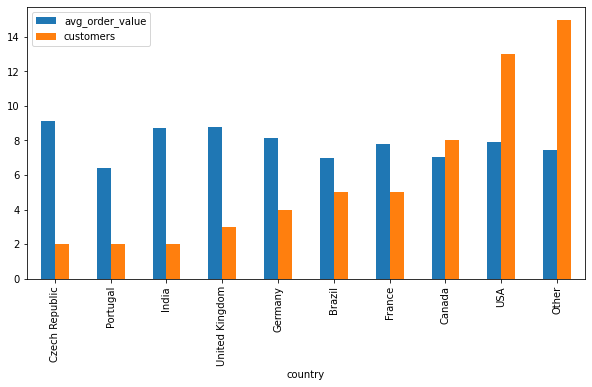

In [9]:
country_sales = country_sales.sort_values(by='customers')
country_sales[['avg_order_value','customers']].plot.bar(figsize = (10,5))

Since we're looking for new countries to advertise into, we should focus on countries that don't have a lot of customers yet.  Rather than just using that as the only metric, we can look at average customer total.  This will help us decide that these customers might be more willing to spend more money for tracks.  The top three would be in order Czech Republic, United Kingdom, and India.  Portugal has the least amount of customers, but the average order value is lower.

# Album Purchasing Habits
We're now tasked with helping management decide if they should they should focus only on purchasing the most popular tracks from each album instead of full albums.

We can help them make this decision by finding out the percentage of purchases that are individual tracks vs entire albums.  Some albums are only one song, so we'll filter these out into a new category.

In [10]:
%%sql
WITH 
    invoice as (
        SELECT 
            il.invoice_id, 
            il.track_id, 
            t.album_id 
        FROM invoice_line as il
        INNER JOIN track as t ON t.track_id = il.track_id
    ),
    album_track_count AS (
        SELECT album_id,
        COUNT(track_id) as count_track
        FROM track
        GROUP BY album_id
    ),
    album_purchased as (
        SELECT 
            atc.count_track, 
            COUNT(i.track_id) as tracks_purchased,
            i.invoice_id, 
            i.album_id,
            CASE
                WHEN atc.count_track = 1 THEN 'Whole Album a Single'
                WHEN COUNT(i.track_id) = atc.count_track THEN 'Full Album Purchase'
                ELSE 'Partial Album Purchase'
                END AS type_of_purchase
        FROM invoice as i
        INNER JOIN album_track_count AS atc ON atc.album_id = i.album_id
        GROUP BY i.invoice_id, i.album_id
    ),
    invoice_count_albums as (
        SELECT
            COUNT(invoice_ID) as invoice_count,
            type_of_purchase
        FROM(
            SELECT
                type_of_purchase,
                invoice_id  
            FROM album_purchased 
            GROUP BY invoice_id)
        GROUP BY type_of_purchase
    ),
    album_purchased_stats as (
        SELECT 
            ap.type_of_purchase as type,
            ica.invoice_count as invoices,
                ROUND(CAST(ica.invoice_count as Float) / 
                (SELECT SUM(invoice_count) FROM invoice_count_albums) * 100,2)
                || '%'
                AS percentage_of_all_invoices,
            SUM(ap.tracks_purchased) as total_tracks 
        FROM album_purchased as ap
        INNER JOIN invoice_count_albums as ica ON ica.type_of_purchase = ap.type_of_purchase
        GROUP by ap.type_of_purchase)

SELECT * from album_purchased_stats



 * sqlite:///chinook.db
Done.


type,invoices,percentage_of_all_invoices,total_tracks
Full Album Purchase,111,18.08%,1473
Partial Album Purchase,497,80.94%,3186
Whole Album a Single,6,0.98%,98


Based on these numbers, buying only individual tracks from record companies would cost them at minimum 18% in revenue.  Since this is almost a fifth of their revenue, I would strongly advocate against their new potential strategy.  Albums that are only a single won't account for much of a difference in either category so filtering them out doesn't make a big difference.

# Most Popular Artist
It may be interesting to see the top 5 most popular artists based on being used in the most playlists

In [11]:
%%sql
with playlist as (
                SELECT 
                    pt.playlist_id,
                    pt.track_id,
                    t.album_id,
                    a.name 
                FROM playlist_track as pt
                    INNER JOIN track as t on t.track_id = pt.track_id
                    INNER JOIN album as al on al.album_id = t.album_id 
                    INNER JOIN artist as a on a.artist_id = al.artist_id
                )
SELECT 
    name as Artist_Name,
    count(name) as Playlist_Count
FROM
(SELECT 
     DISTINCT name,
     playlist_id 
 from playlist)
    GROUP BY name
    ORDER by Playlist_Count DESC
    LIMIT 5;

 * sqlite:///chinook.db
Done.


Artist_Name,Playlist_Count
Eugene Ormandy,7
The King's Singers,6
English Concert & Trevor Pinnock,6
Berliner Philharmoniker & Herbert Von Karajan,6
Academy of St. Martin in the Fields & Sir Neville Marriner,6


It seems that the top 5 srtists that appear on the most different playlists are predominately classical music.  However, if we're most interested in the artists that appears the most frequently, regardless of playlist, we can group them in a different way.  

In [12]:
%%sql
with playlist as (
                SELECT 
                    pt.playlist_id,
                    pt.track_id,
                    t.album_id,
                    a.name 
                FROM playlist_track as pt
                    INNER JOIN track as t on t.track_id = pt.track_id
                    INNER JOIN album as al on al.album_id = t.album_id 
                    INNER JOIN artist as a on a.artist_id = al.artist_id
                )
SELECT name, count(name) FROM playlist group by name order by count(name) desc LIMIT 20;

 * sqlite:///chinook.db
Done.


name,count(name)
Iron Maiden,516
U2,333
Metallica,296
Led Zeppelin,252
Deep Purple,226
Lost,184
Pearl Jam,177
Faith No More,145
Eric Clapton,145
Lenny Kravitz,143


Here we can see that Iron Maiden is by far the most frequent and that even looking at the top 20, it's predeominantely Rock which makes more sense as we learned earlier that Rock accounts for over 50% of tracks in the store.

# Quantity of tracks purchased vs not purchased?
Here we can see potentially the amount of tracks that haven't been purchased.

In [13]:
%%sql
    with purchased_tracks as (
                            SELECT 
                                count(DISTINCT il.track_id) as purchased_track_count,
                                (SELECT count(DISTINCT track_id) FROM track) as total_track_count
                            FROM invoice_line as il
    )
SELECT 
    *,
    round(CAST(purchased_track_count as float) / CAST(total_track_count as float),2) as purchased_percent,
    round(1 - CAST(purchased_track_count as float) / CAST(total_track_count as float),2) as not_purchased_percent
FROM purchased_tracks

 * sqlite:///chinook.db
Done.


purchased_track_count,total_track_count,purchased_percent,not_purchased_percent
1806,3503,0.52,0.48


Almost 50% of the entire store has not been purchased.  There could be an oppurtunity to consolidate the store into more frequently purchased tracks if the store is paying any upfront fees for having the non purchased tracks.

# Conclusion
In this project we used SQL to run a lot of different analyses on the Chinook music store.  If management had ideas for consolidation or boosting revenues, we were able to show whether or not their ideas would help or be a detriment.